# Optimizing Laptop Price Predictions: Regression Modeling Exploration

## Contents 
1. Main Objective
2. Dataset Description
3. Data Exploration and Cleaning
4. Regression
>- Linear Regression
>- Lasso Regression
>- Ridge Regression
5. Cross Validation
6. Summary

## 1. Main Objective

Predict, in the best possible way, the sales price of the Laptops based on their characteristics using different linear regression models, including linear regression, Lasso, Ridge, and Elastic Net. Apply feature transformation and scaling techniques to enhance model performance. Employ cross-validation methods to ensure robust model evaluation and selection.

Data source: [Kaggle](https://www.kaggle.com/muhammetvarl/laptop-price)

## 2. Dataset Description

The dataset used for this laptop price prediction project is sourced from Kaggle and comprises information related to various laptop specifications. The dataset consists of 1320 rows and 13 columns including the following columns:

- Company (String): The laptop manufacturer.
- Product (String): The brand and model of the laptop.
- TypeName (String): The type of laptop (e.g., Notebook, Ultrabook, Gaming, etc.).
- Inches (Numeric): The screen size of the laptop.
- ScreenResolution (String): The screen resolution of the laptop.
- Cpu (String): The Central Processing Unit (CPU) of the laptop.
- Ram (String): The amount of Random Access Memory (RAM) in the laptop.
- Memory (String): The type of hard disk or SSD memory in the laptop.
- GPU (String): The Graphics Processing Unit (GPU) of the laptop.
- OpSys (String): The operating system installed on the laptop.
- Weight (String): The weight of the laptop.
- Price_euros (Numeric): The price of the laptop in Euros.

In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Setting seaborn visualizations as default
sns.set()
%matplotlib inline

# Importing preprocessing tools from scikit-learn
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, PolynomialFeatures

# Importing model selection tools from scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_predict

# Importing linear regression models
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV

# Importing scikit-learn pipeline for organizing preprocessing and modeling steps
from sklearn.pipeline import Pipeline

# Importing metrics for model evaluation
from sklearn.metrics import mean_squared_error, r2_score

# Custom function to calculate Root Mean Squared Error (RMSE)
def rmse(y_true, y_predicted):
    """
    Calculate Root Mean Squared Error (RMSE).

    Parameters:
    - y_true: actual values
    - y_predicted: predicted values

    Returns:
    - rmse_val: calculated RMSE
    """
    rmse_val = np.sqrt(mean_squared_error(y_true, y_predicted))
    return rmse_val

In [5]:
df = pd.read_csv('laptop_price.csv', encoding='ISO-8859-1')
df.shape

(1303, 13)

In [7]:
# Examine the columns, rows, and missing data

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         1303 non-null   int64  
 1   Company           1303 non-null   object 
 2   Product           1303 non-null   object 
 3   TypeName          1303 non-null   object 
 4   Inches            1303 non-null   float64
 5   ScreenResolution  1303 non-null   object 
 6   Cpu               1303 non-null   object 
 7   Ram               1303 non-null   object 
 8   Memory            1303 non-null   object 
 9   Gpu               1303 non-null   object 
 10  OpSys             1303 non-null   object 
 11  Weight            1303 non-null   object 
 12  Price_euros       1303 non-null   float64
dtypes: float64(2), int64(1), object(10)
memory usage: 132.5+ KB


,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


In [8]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
laptop_ID,1303.0,660.155794,381.172104,1.0,331.5,659.0,990.50,1320.0
Inches,1303.0,15.017191,1.426304,10.1,14.0,15.6,15.60,18.4
Price_euros,1303.0,1123.686992,699.009043,174.0,599.0,977.0,1487.88,6099.0


In [9]:
# Show the number of unique values for each column
for col in df:
    print(col, len(df[col].unique()))


laptop_ID 1303
Company 19
Product 618
TypeName 6
Inches 18
ScreenResolution 40
Cpu 118
Ram 9
Memory 39
Gpu 110
OpSys 9
Weight 179
Price_euros 791


**TDs**

1. We will need to **transform** *Cpu*, *Ram*, *Memory*, *ScreenResolution* and *GPU*.

2. We will **drop** *laptop_ID* and *Product* when training the model.

3. We can directly use **dummy variables** for *Company*, *TypeName*, and *OpSys*.

4. We can also use **scaled values** for *Inches* and *Weight*.

## 3. Data Exploration and Cleaning

In [11]:
# First we copy df to a new dataframe and work on that dataframe.
df2 = df.copy()

# X and Y
y_col = "Price_euros"

y = df2[y_col]
df2 = df2.drop(y_col, axis=1)

#### Transformation of CPU, GPU, Ram, Memory, Screen resolution, and Weight

In [13]:
#  Display all unique values in columns of interest
columns_to_check = ['Cpu', 'Ram', 'Memory', 'Gpu', 'ScreenResolution']

for column in columns_to_check:
    unique_values = df2[column].unique()
    print(f"Unique values in column '{column}': {unique_values}")


Unique values in column 'Cpu': ['Intel Core i5 2.3GHz' 'Intel Core i5 1.8GHz'
 'Intel Core i5 7200U 2.5GHz' 'Intel Core i7 2.7GHz'
 'Intel Core i5 3.1GHz' 'AMD A9-Series 9420 3GHz' 'Intel Core i7 2.2GHz'
 'Intel Core i7 8550U 1.8GHz' 'Intel Core i5 8250U 1.6GHz'
 'Intel Core i3 6006U 2GHz' 'Intel Core i7 2.8GHz'
 'Intel Core M m3 1.2GHz' 'Intel Core i7 7500U 2.7GHz'
 'Intel Core i7 2.9GHz' 'Intel Core i3 7100U 2.4GHz'
 'Intel Atom x5-Z8350 1.44GHz' 'Intel Core i5 7300HQ 2.5GHz'
 'AMD E-Series E2-9000e 1.5GHz' 'Intel Core i5 1.6GHz'
 'Intel Core i7 8650U 1.9GHz' 'Intel Atom x5-Z8300 1.44GHz'
 'AMD E-Series E2-6110 1.5GHz' 'AMD A6-Series 9220 2.5GHz'
 'Intel Celeron Dual Core N3350 1.1GHz' 'Intel Core i3 7130U 2.7GHz'
 'Intel Core i7 7700HQ 2.8GHz' 'Intel Core i5 2.0GHz'
 'AMD Ryzen 1700 3GHz' 'Intel Pentium Quad Core N4200 1.1GHz'
 'Intel Atom x5-Z8550 1.44GHz' 'Intel Celeron Dual Core N3060 1.6GHz'
 'Intel Core i5 1.3GHz' 'AMD FX 9830P 3GHz' 'Intel Core i7 7560U 2.4GHz'
 'AMD E-Series 

In [15]:
# CPU
df2['Cpu'] = df2['Cpu'].replace(regex=["Pentium Dual Core"], value="2-Core")
df2['Cpu'] = df2['Cpu'].replace(regex=["Pentium Quad Core"], value="4-Core")
df2['Cpu'] = df2['Cpu'].replace(regex=["Celeron Dual Core"], value="2-Core")
df2['Cpu'] = df2['Cpu'].replace(regex=["Celeron Quad Core"], value="4-Core")
df2[['CPU','Model', 'Perform', 'Freq']] = df2["Cpu"].str.split(" ",3, expand=True)

df2['Freq'] = df2['Freq'].str[-7:-3]
df2['Freq'] = df2['Freq'].replace(regex=["V6"], value="")
df2['Freq'] = df2['Freq'].replace(regex=["6U"], value="")
df2['Freq'] = df2['Freq'].astype(float)

C:\Users\pc\AppData\Local\Temp\ipykernel_7452\2291924092.py:6: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df2[['CPU','Model', 'Perform', 'Freq']] = df2["Cpu"].str.split(" ",3, expand=True)


In [16]:
# GPU
df2[['GPU','Others']] = df2["Gpu"].str.split(" ",1, expand=True)

C:\Users\pc\AppData\Local\Temp\ipykernel_7452\4013823753.py:2: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df2[['GPU','Others']] = df2["Gpu"].str.split(" ",1, expand=True)


In [17]:
# Ram
df2["Ram"] = df2['Ram'].replace(regex=["GB"], value="")
df2['Ram'] = df2['Ram'].astype(float)

In [18]:
# Memory
df2['Memory'] = df2['Memory'].replace(regex=["1TB"], value="1024GB")
df2['Memory'] = df2['Memory'].replace(regex=["1.0TB"], value="1024GB")
df2['Memory'] = df2['Memory'].replace(regex=["2TB"], value="2048GB")
df2['Memory'] = df2['Memory'].str[:6]
df2['Memory'] = df2['Memory'].replace(regex=["GB","G","GB S", "S", "H", "F"], value="")
df2['Memory'] = df2['Memory'].astype(float)

In [19]:
# ScreenResolution
df2["ScreenResolution"] = df2["ScreenResolution"].str[-9:]

In [20]:
# Weight
df2['Weight'] = df2['Weight'].str[:-2]
df2['Weight'] = df2['Weight'].astype(float)

In [24]:
df2.sample(n=5, random_state=42)

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,CPU,Model,Perform,Freq,GPU,Others
479,486,Toshiba,Portege X30-D-10J,Notebook,13.3,1920x1080,Intel Core i5 7200U 2.5GHz,8.0,256.0,Intel HD Graphics 620,Windows 10,1.05,Intel,Core,i5,2.5,Intel,HD Graphics 620
1022,1036,HP,Spectre 13-V100nv,Notebook,13.3,1920x1080,Intel Core i5 7200U 2.5GHz,8.0,256.0,Intel HD Graphics 620,Windows 10,1.11,Intel,Core,i5,2.5,Intel,HD Graphics 620
298,303,Lenovo,IdeaPad 310-15ABR,Notebook,15.6,1920x1080,AMD A10-Series 9600P 2.4GHz,6.0,1024.0,AMD Radeon R5 430,Windows 10,2.40,AMD,A10-Series,9600P,2.4,AMD,Radeon R5 430
1265,1283,Lenovo,IdeaPad Y700-15ISK,Notebook,15.6,1920x1080,Intel Core i7 6700HQ 2.6GHz,8.0,1024.0,Nvidia GeForce GTX 960M,Windows 10,2.60,Intel,Core,i7,2.6,Nvidia,GeForce GTX 960M
774,783,HP,EliteBook 820,Ultrabook,12.5,1366x768,Intel Core i5 6200U 2.3GHz,4.0,256.0,Intel HD Graphics 520,Windows 10,1.26,Intel,Core,i5,2.3,Intel,HD Graphics 520


#### Dropping unwanted columns

In [25]:
df2 = df2.drop(['laptop_ID', 'Product', 'Cpu','Gpu','Perform','Others'], axis = 1)

In [26]:
df2.head()

,Company,TypeName,Inches,ScreenResolution,Ram,Memory,OpSys,Weight,CPU,Model,Freq,GPU
0,Apple,Ultrabook,13.3,2560x1600,8.0,128.0,macOS,1.37,Intel,Core,2.3,Intel
1,Apple,Ultrabook,13.3,1440x900,8.0,128.0,macOS,1.34,Intel,Core,1.8,Intel
2,HP,Notebook,15.6,1920x1080,8.0,256.0,No OS,1.86,Intel,Core,2.5,Intel
3,Apple,Ultrabook,15.4,2880x1800,16.0,512.0,macOS,1.83,Intel,Core,2.7,AMD
4,Apple,Ultrabook,13.3,2560x1600,8.0,256.0,macOS,1.37,Intel,Core,3.1,Intel


#### Prepare the data for one-hot encoding of categorical variables 

In [27]:
# Identify columns with object (categorical) data types
mask = df2.dtypes == np.object
categorical_cols = df2.columns[mask]

# Display the list of categorical columns
categorical_cols

# Identify columns with float (numerical) data types
mask = df2.dtypes == np.float
numerical_cols = df2.columns[mask]

# Display the list of numerical columns
numerical_cols

# Arrange the columns with numerical types first followed by categorical types
arranged_col = numerical_cols.tolist() + categorical_cols.tolist()
df2 = df2[arranged_col]

# Display the DataFrame with columns arranged
df2.head()

C:\Users\pc\AppData\Local\Temp\ipykernel_7452\1407721196.py:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = df2.dtypes == np.object
C:\Users\pc\AppData\Local\Temp\ipykernel_7452\1407721196.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = df2.dtypes == np.float


,Inches,Ram,Memory,Weight,Freq,Company,TypeName,ScreenResolution,OpSys,CPU,Model,GPU
0,13.3,8.0,128.0,1.37,2.3,Apple,Ultrabook,2560x1600,macOS,Intel,Core,Intel
1,13.3,8.0,128.0,1.34,1.8,Apple,Ultrabook,1440x900,macOS,Intel,Core,Intel
2,15.6,8.0,256.0,1.86,2.5,HP,Notebook,1920x1080,No OS,Intel,Core,Intel
3,15.4,16.0,512.0,1.83,2.7,Apple,Ultrabook,2880x1800,macOS,Intel,Core,AMD
4,13.3,8.0,256.0,1.37,3.1,Apple,Ultrabook,2560x1600,macOS,Intel,Core,Intel


#### One-hot encoding analysis of sorts

In [28]:
# Count the number of unique values in each categorical column
num_ohc_cols = (df2[categorical_cols]
                .apply(lambda x: x.nunique())
                .sort_values(ascending=False))

# Filter out columns with only one unique value
small_num_ohc_cols = num_ohc_cols.loc[num_ohc_cols > 1]

# Subtract 1 from the count, as one-hot encoding creates one less column than categories
small_num_ohc_cols -= 1

# Sum the counts of one-hot encoded columns
total_ohc_cols = small_num_ohc_cols.sum()

# Display the total number of one-hot encoded columns
total_ohc_cols

65

#### One-hot encoding

In [29]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Copy of the data
df3 = df2.copy()

# The encoders
le = LabelEncoder()
ohc = OneHotEncoder()

# Loop through each categorical column to perform one-hot encoding
for col in num_ohc_cols.index:
    
    # Integer encode the string categories using LabelEncoder
    dat = le.fit_transform(df3[col]).astype(np.int)
    
    # Remove the original column from the dataframe
    df3 = df3.drop(col, axis=1)

    # One hot encode the data; this returns a sparse array
    new_dat = ohc.fit_transform(dat.reshape(-1, 1))

    # Create unique column names for the new one-hot encoded columns
    n_cols = new_dat.shape[1]
    col_names = ['_'.join([col, str(x)]) for x in range(n_cols)]

    # Create the new dataframe with one-hot encoded columns
    df4 = pd.DataFrame(new_dat.toarray(), 
                          index=df3.index, 
                          columns=col_names)

    # Append the new data to the original dataframe
    df3 = pd.concat([df3, df4], axis=1)


C:\Users\pc\AppData\Local\Temp\ipykernel_7452\545226511.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dat = le.fit_transform(df3[col]).astype(np.int)
C:\Users\pc\AppData\Local\Temp\ipykernel_7452\545226511.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release 

In [30]:
df3.head()

,Inches,Ram,Memory,Weight,Freq,Company_0,Company_1,Company_2,Company_3,Company_4,...,TypeName_3,TypeName_4,TypeName_5,GPU_0,GPU_1,GPU_2,GPU_3,CPU_0,CPU_1,CPU_2
0,13.3,8.0,128.0,1.37,2.3,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,13.3,8.0,128.0,1.34,1.8,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,15.6,8.0,256.0,1.86,2.5,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,15.4,16.0,512.0,1.83,2.7,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,13.3,8.0,256.0,1.37,3.1,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


#### Scale features that needs to be scaled: Inches, Ram, Memory, Weight, and Frequencies using the StandardScaler.

In [31]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
s = StandardScaler()

# Apply StandardScaler to numerical columns in df3
laptop_ss_array = s.fit_transform(df3[numerical_cols])

# Create a DataFrame from the scaled numerical columns with specific column names
laptop_ss = pd.DataFrame(laptop_ss_array, columns=['Inches_ss', 'Ram_ss', 'Memory_ss', 'Weight_ss', 'Freq_sss'])

# Concatenate the scaled numerical columns with the original one-hot encoded DataFrame
laptop_ohc_ss = pd.concat([df3, laptop_ss], axis=1)

# Drop the original numerical columns from the DataFrame
laptop_ohc_ss = laptop_ohc_ss.drop(numerical_cols, axis=1)

# Display the resulting DataFrame with scaled numerical columns
laptop_ohc_ss.head()


,Company_0,Company_1,Company_2,Company_3,Company_4,Company_5,Company_6,Company_7,Company_8,Company_9,...,GPU_2,GPU_3,CPU_0,CPU_1,CPU_2,Inches_ss,Ram_ss,Memory_ss,Weight_ss,Freq_sss
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,-1.204407,-0.075195,-0.874044,-1.005283,0.002426
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,-1.204407,-0.075195,-0.874044,-1.050381,-0.985431
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.408772,-0.075195,-0.524218,-0.268684,0.397569
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.268495,1.498767,0.175433,-0.313782,0.792712
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,-1.204407,-0.075195,-0.524218,-1.005283,1.582997


#### Scale label (y) data as well

In [32]:
s = StandardScaler()

y_shaped = y.values.reshape(len(y),1)
y_ss = s.fit_transform(y_shaped)

## 4. Regression

This section involves the following steps:

1. Splitting the dataset into training and testing sets using the sklearn library.
2. Exploring various regression techniques to build our models.

The regression techniques covered in this section are:
- Linear Regression
- Lasso Regression
- Ridge Regression

In [33]:
# Importing the necessary library for train-test splitting
from sklearn.model_selection import train_test_split

# Creating copies of the features (X_data) and target variable (y_data)
X_data = laptop_ohc_ss.copy()
y_data = y_ss.copy()

# Splitting the data into training and testing sets
# - X_train and y_train represent the features and target variable for training.
# - X_test and y_test represent the features and target variable for testing.
# - The test_size parameter determines the proportion of the dataset used for testing (30% in this case).
# - The random_state parameter ensures reproducibility of the split.
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, 
                                                    test_size=0.3, random_state=42)

#### Linear Regression

In [55]:
# Importing the Linear Regression model from scikit-learn
from sklearn.linear_model import LinearRegression

# Creating an instance of Linear Regression and fitting the model using training data
linearRegression = LinearRegression().fit(X_train, y_train)

# Calculating root mean squared error (RMSE) for the Linear Regression model on the testing set
linearRegression_rmse = rmse(y_test, linearRegression.predict(X_test))

# Creating an empty list to store error metrics
error_df = list()

# Appending RMSE values to the error list for later analysis or comparison
error_df.append(pd.Series({'train': rmse(y_train, linearRegression.predict(X_train)),
                           'test' : linearRegression_rmse},
                           name='LR'))

# Printing RMSE values for the training and testing sets
print('train:', rmse(y_train, linearRegression.predict(X_train)))
print('test:', linearRegression_rmse)


train: 0.43784387499586086
test: 0.49315203512278566


#### Generate a scatter plot to visualize the performance of the Linear Regression model

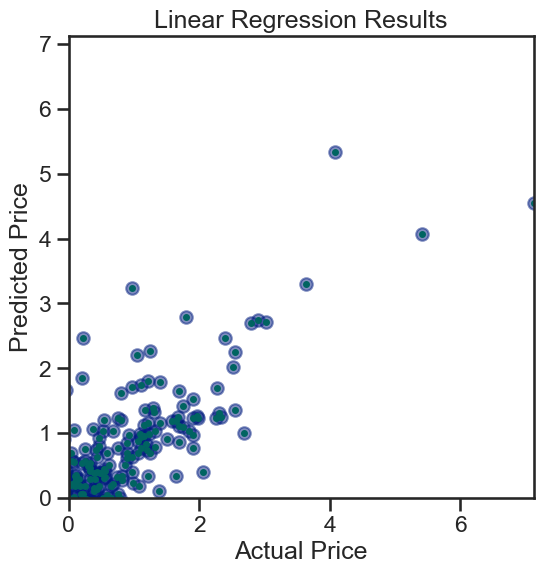

In [39]:
# Setting the visual style using seaborn
sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('dark')

# Creating a figure with a specified size
f = plt.figure(figsize=(6, 6))

# Creating an axes object for plotting
ax = plt.axes()

# Plotting the predicted values against the actual values from the testing set
ax.plot(y_test, linearRegression.predict(X_test), 
         marker='o', ls='', ms=4.0, color='#006461')

# Adding a scatter plot for better visualization, adjusting transparency
ax.scatter(y_test, linearRegression.predict(X_test), alpha=.5)

# Setting the limits and labels for the x and y axes
lim = (0, y_test.max())
ax.set(xlabel='Actual Price', 
       ylabel='Predicted Price', 
       xlim=lim,
       ylim=lim,
       title='Linear Regression Results');

#### LASSO Regression

In [56]:
# Importing necessary libraries from scikit-learn
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures

# Initializing a Lasso regression model with specified hyperparameters
lasso = Lasso(alpha=0.001, max_iter=10000)

# Fitting the Lasso model using the training data
lasso.fit(X_train, y_train)

# Calculating root mean squared error (RMSE) for the Lasso model on the training and testing sets
error_df.append(pd.Series({'train': rmse(y_train, lasso.predict(X_train)),
                           'test' : rmse(y_test, lasso.predict(X_test))},
                           name='Lasso'))

# Printing RMSE values for the training and testing sets
print('train:', rmse(y_train, lasso.predict(X_train)))
print('test:', rmse(y_test, lasso.predict(X_test)))


train: 0.44394101507710915
test: 0.5054357386476939


#### Generate a scatter plot to visualize the performance of the LASSO Regression model

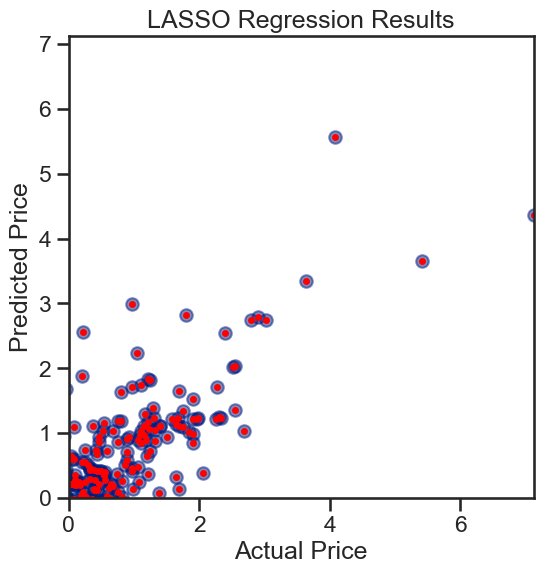

In [45]:
# Setting the visual style using seaborn
sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('dark')

# Creating a figure with a specified size
f = plt.figure(figsize=(6, 6))

# Creating an axes object for plotting
ax = plt.axes()

# Plotting the predicted values against the actual values from the testing set
ax.plot(y_test, lasso.predict(X_test), 
         marker='o', ls='', ms=4.0, color='red')

# Adding a scatter plot for better visualization, adjusting transparency
ax.scatter(y_test, lasso.predict(X_test), alpha=.5)

# Setting the limits and labels for the x and y axes
lim = (0, y_test.max())
ax.set(xlabel='Actual Price', 
       ylabel='Predicted Price', 
       xlim=lim,
       ylim=lim,
       title='LASSO Regression Results');

#### Ridge regression

In [57]:
# Importing necessary library from scikit-learn
from sklearn.linear_model import Ridge

# Initializing a Ridge regression model with a specified regularization strength
ridge = Ridge(alpha=0.001)

# Fitting the Ridge model using the training data
ridge.fit(X_train, y_train)

# Calculating root mean squared error (RMSE) for the Ridge model on the training and testing sets
error_df.append(pd.Series({'train': rmse(y_train, ridge.predict(X_train)),
                           'test' : rmse(y_test, ridge.predict(X_test))},
                           name='Ridge'))

# Printing RMSE values for the training and testing sets
print('train:', rmse(y_train, ridge.predict(X_train)))
print('test:', rmse(y_test, ridge.predict(X_test)))


train: 0.4378438786589009
test: 0.4931548573690608


#### Generate a scatter plot to visualize the performance of the Ridge Regression model

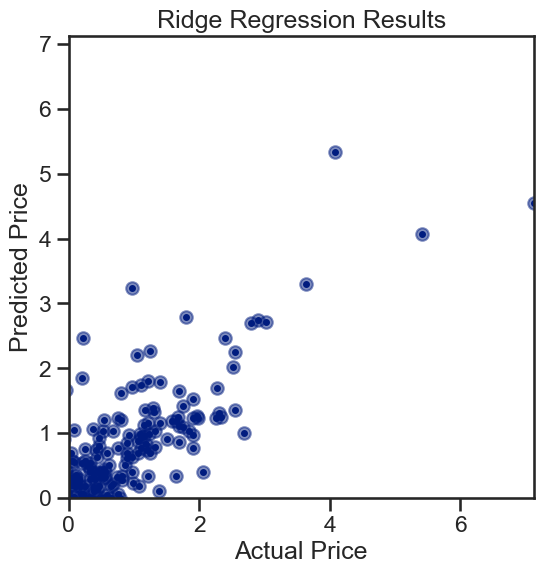

In [47]:
# Setting the visual style using seaborn
sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('dark')

# Creating a figure with a specified size
f = plt.figure(figsize=(6, 6))

# Creating an axes object for plotting
ax = plt.axes()

# Plotting the predicted values against the actual values from the testing set
ax.plot(y_test, ridge.predict(X_test), 
         marker='o', ls='', ms=4.0)

# Adding a scatter plot for better visualization, adjusting transparency
ax.scatter(y_test, ridge.predict(X_test), alpha=.5)

# Setting the limits and labels for the x and y axes
lim = (0, y_test.max())
ax.set(xlabel='Actual Price', 
       ylabel='Predicted Price', 
       xlim=lim,
       ylim=lim,
       title='Ridge Regression Results');

#### Display Error Metrics of Models

In [58]:
error_df = pd.concat(error_df, axis=1)
error_df

,LR,Lasso,Ridge
train,0.437844,0.443941,0.437844
test,0.493152,0.505436,0.493155


## 5. Cross-Validation
This section focuses on conducting cross-validation using GridSearch CV, Lasso CV, and Ridge CV techniques.

#### GridSearch CV

In [59]:
# Importing necessary libraries for cross-validation
from sklearn.model_selection import GridSearchCV

# Defining the number of folds for cross-validation (e.g., 5 or 10)
num_folds = 5

# Creating a KFold object for cross-validation
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Defining the estimator using a pipeline with StandardScaler, PolynomialFeatures, and Ridge regression
estimator = Pipeline([("scaler", StandardScaler()),
                      ("polynomial_features", PolynomialFeatures()),
                      ("ridge_regression", Ridge())])

# Defining a dictionary of hyperparameters for grid search
params = {
    'polynomial_features__degree': [1, 2, 3],
    'ridge_regression__alpha': np.geomspace(4, 20, 30)
}

# Performing GridSearchCV with k-fold cross-validation
grid = GridSearchCV(estimator, params, cv=kf)

# Fitting the grid search to the training data
grid.fit(X_train, y_train)

# Making predictions on the testing set using the best model from grid search
y_predict = grid.predict(X_test)

# Printing the root mean squared error (RMSE) for the testing set
print(rmse(y_test, grid.predict(X_test)))


0.49262318912366326


#### Lasso CV

In [61]:
# Importing necessary library for LassoCV
from sklearn.linear_model import LassoCV

# Defining a set of alpha values for Lasso regularization
alphas2 = np.array([1e-5, 5e-5, 0.0001, 0.0005])

# Initializing LassoCV with specified alpha values, maximum iterations, and cross-validation folds
lassoCV = LassoCV(alphas= alphas2,
                  max_iter= 50000,
                  cv=3).fit(X_train, y_train)

# Calculating root mean squared error (RMSE) for LassoCV on the testing set
lassoCV_rmse = rmse(y_test, lassoCV.predict(X_test))

# Printing the selected alpha value and the corresponding RMSE
print(lassoCV.alpha_, lassoCV_rmse)

0.0005 0.4983255593964739


C:\Users\pc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1568: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### Ridge CV

In [62]:
# Importing necessary library for RidgeCV
from sklearn.linear_model import RidgeCV

# Defining a set of alpha values for Ridge regularization
alphas = [0.005, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 80]

# Initializing RidgeCV with specified alpha values and cross-validation folds
ridgeCV = RidgeCV(alphas=alphas, 
                  cv=4).fit(X_train, y_train)

# Calculating root mean squared error (RMSE) for RidgeCV on the testing set
ridgeCV_rmse = rmse(y_test, ridgeCV.predict(X_test))

# Printing the selected alpha value and the corresponding RMSE
print(ridgeCV.alpha_, ridgeCV_rmse)

3.0 0.5057361835668316


## 6. Summary

In this project, we aimed to predict laptop prices based on their components using various regression techniques and advanced data preprocessing methods. Ridge regression with GridSearch cross-validation yielded the best results (RMSE=0.492). However,  the model's performance could be further improved by incorporating polynomial features and refining the dataset for a more robust analysis.